#### References

Dataset: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/blob/master/Sarcasm_Headlines_Dataset.json <br>
GloVe Model: https://github.com/stanfordnlp/GloVe?tab=readme-ov-file <br>
Sarcasm Detection: https://www.kaggle.com/code/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy#OVERVIEW-OF-DATASET <br>

#### Libraries

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text
from keras.utils import pad_sequences, Sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

#### Data Viz. & Preprocessing

In [3]:
df = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
df.isna().sum() # Checking for NaN values

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [5]:
del df['article_link'] # Deleting this column as it is of no use


In [6]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

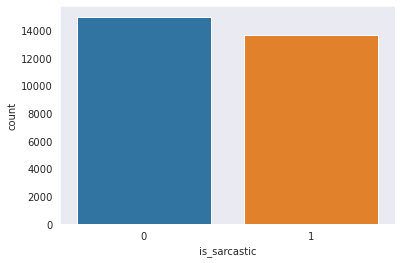

In [7]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

In [8]:
#nltk.download('stopwords')

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#### Data Cleaning

In [90]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)


def remove_urls(text):
    return re.sub(r'http\S+', '', text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)


def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    text = remove_urls(text)
    return text


df['headline']=df['headline'].apply(denoise_text)

#### Non-sarcastic Text Wordcloud

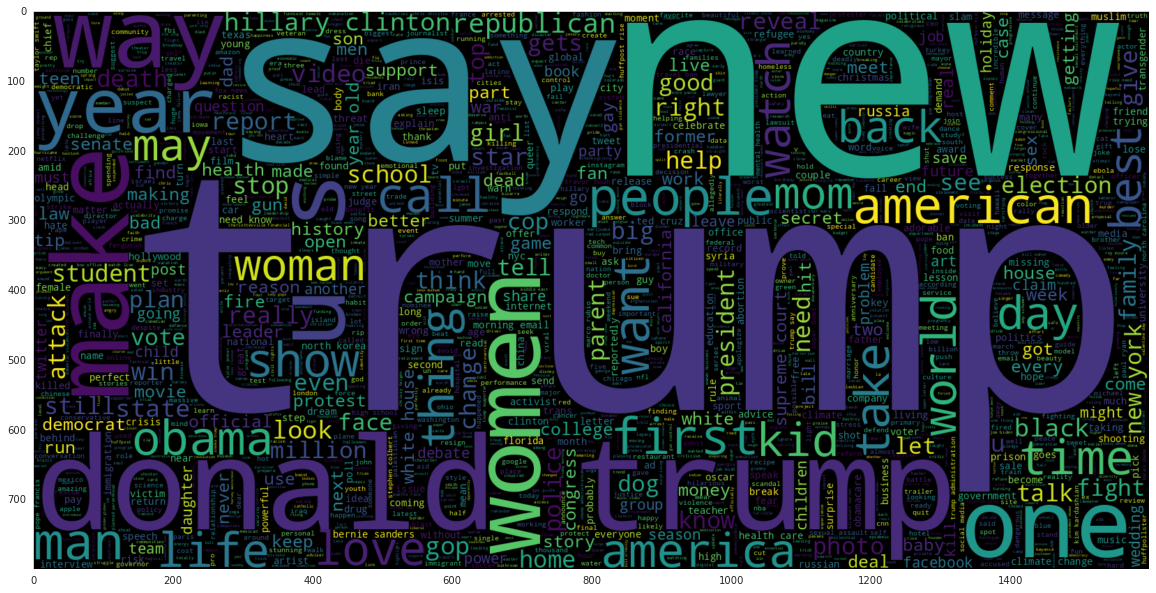

In [10]:
plt.figure(figsize = (20,20))

wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

#### Sarcastic Text Wordcloud

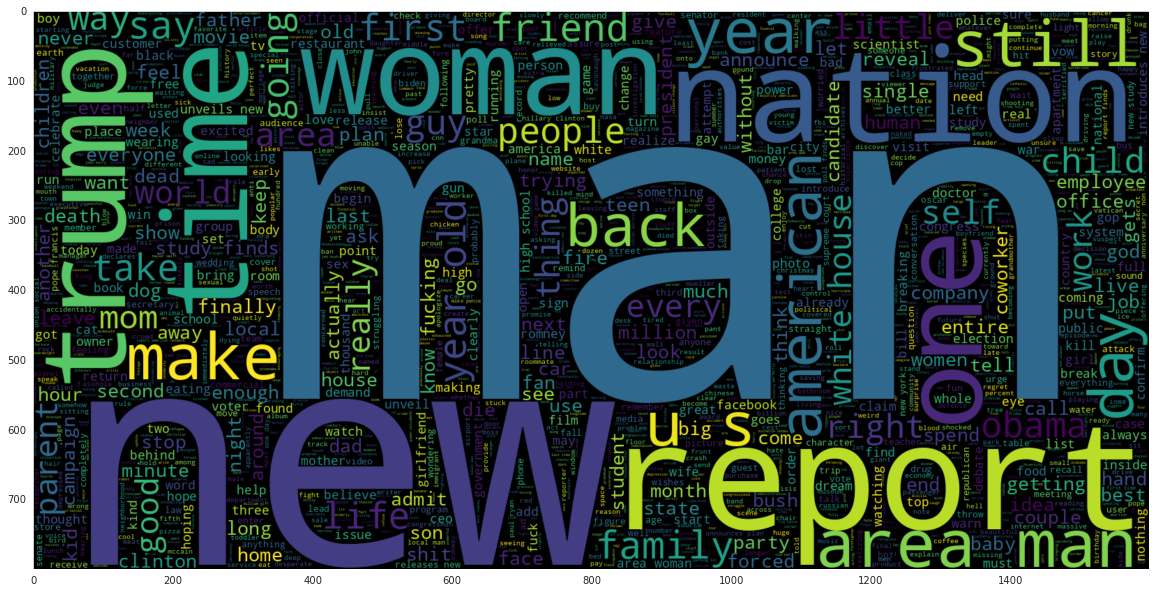

In [11]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

#### Checking Character Count

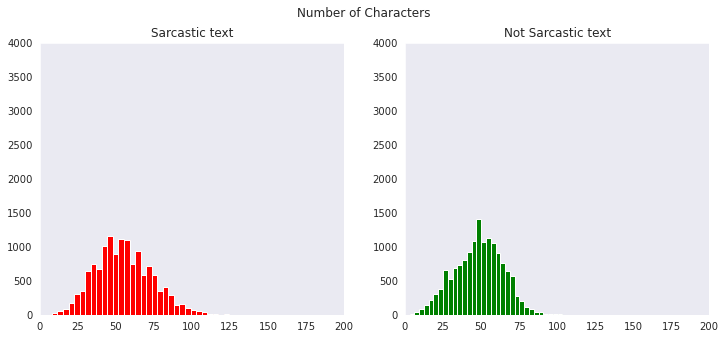

In [77]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

text_len=df[df['is_sarcastic']==1]['headline'].str.len()
plt.hist(text_len, color='red', bins=200)
plt.title('Sarcastic text')
plt.xlim(0, 200)
plt.ylim(0, 4000)


plt.subplot(1, 2, 2)

text_len=df[df['is_sarcastic']==0]['headline'].str.len()
plt.hist(text_len, color='green', bins=50)
plt.title('Not Sarcastic text')
plt.xlim(0, 200)
plt.ylim(0, 4000)

plt.suptitle('Number of Characters')
plt.show()

In [14]:
# CONVERTING TO GENSIM FORMAT

words = []
for i in df.headline.values:
    words.append(i.split())
    
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', '9', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

In [15]:
import gensim

# Dimension of vectors we are generating
EMBEDDING_DIM = 200

# Creating Word Vectors by Word2Vec Method
w2v_model = gensim.models.Word2Vec(sentences = words , vector_size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [16]:
# Vocab size
len(w2v_model.wv.key_to_index)

38071

38071 words have been represented by a 100-dimensional vector.

In [21]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = keras.utils.pad_sequences(tokenized_train, maxlen = 20)

In [22]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [23]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [29]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model.wv, tokenizer.word_index)

#### Training W2V Model

In [30]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 200)           7614400   
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 256)          336896    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,007,041
Trainable params: 8,007,041
Non-trainable params: 0
_________________________________________________________________


In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [33]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

Epoch 1/3
157/157 [==============================] - 37s 192ms/step - loss: 0.5102 - acc: 0.7439 - val_loss: 0.4189 - val_acc: 0.8152
Epoch 2/3
157/157 [==============================] - 31s 195ms/step - loss: 0.1453 - acc: 0.9450 - val_loss: 0.4972 - val_acc: 0.7991
Epoch 3/3
157/157 [==============================] - 30s 190ms/step - loss: 0.0379 - acc: 0.9875 - val_loss: 0.8145 - val_acc: 0.8014


In [34]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

627/627 [==============================] - 4s 7ms/step - loss: 0.0096 - acc: 0.9976
Accuracy of the model on Training Data is -  99.76039528846741
269/269 [==============================] - 2s 7ms/step - loss: 0.8145 - acc: 0.8014
Accuracy of the model on Testing Data is -  80.14209270477295


#### W2V Analysis

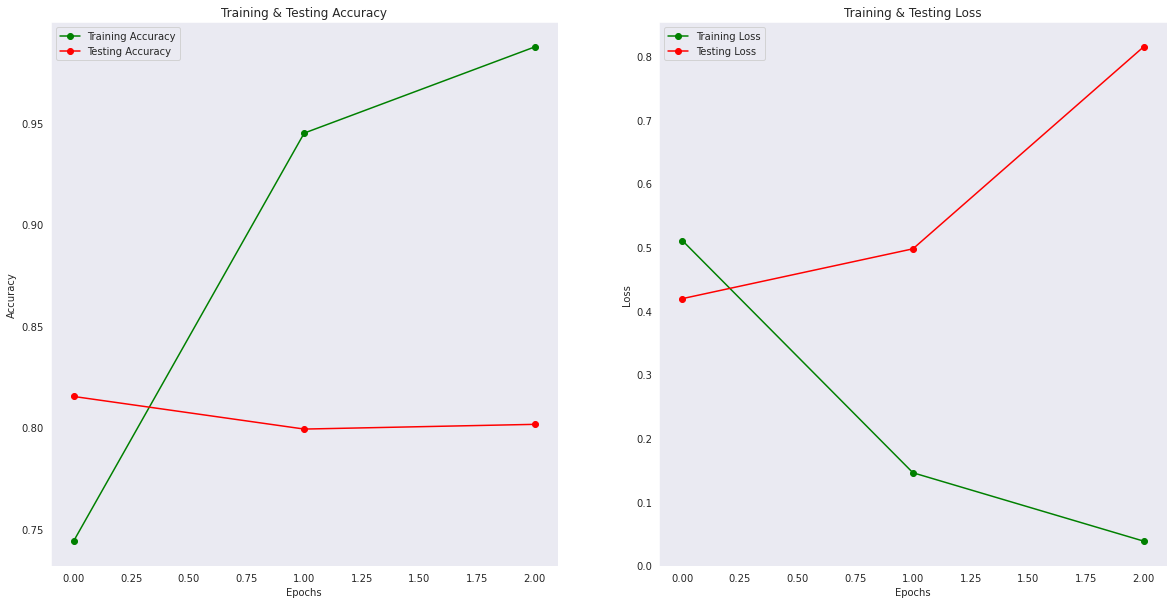

In [35]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

#### Problem: The model is overfitting.

In [37]:
pred = model.predict(x_test)
pred[:5]

269/269 [==============================] - 2s 7ms/step


array([[9.9892479e-01],
       [4.7052786e-04],
       [9.9949610e-01],
       [4.6101486e-04],
       [9.9916607e-01]], dtype=float32)

In [43]:
pred = np.where(pred > 0.5, 1, 0)
pred

array([[1],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]])

In [44]:
cm = confusion_matrix(y_test,pred)
cm

array([[3674,  886],
       [ 819, 3207]])

<AxesSubplot:>

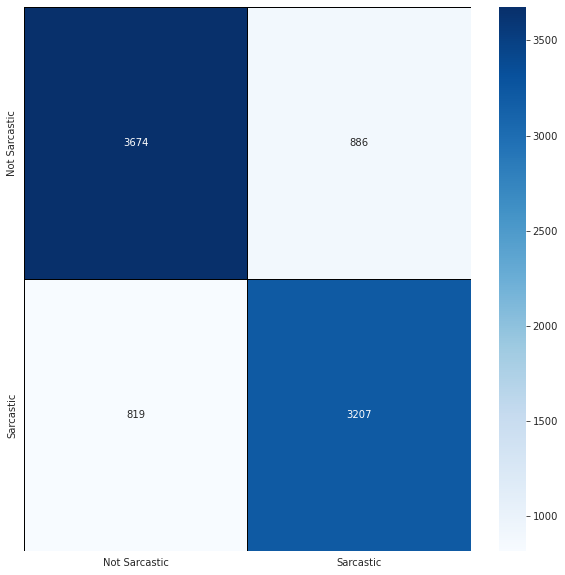

In [45]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])


#### GloVe

Maximum Length = 200, add padding to news with less than 200 words and truncate long ones.

In [46]:
x_train,x_test,y_train,y_test = train_test_split(df.headline,df.is_sarcastic, test_size = 0.3 , random_state = 0)

In [47]:
max_features = 35000
maxlen = 200

In [48]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = keras.utils.pad_sequences(tokenized_train, maxlen=maxlen)


In [49]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = keras.utils.pad_sequences(tokenized_test, maxlen=maxlen)



In [53]:
EMBEDDING_FILE = 'glove.twitter.27B.200d.txt'

In [54]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [55]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3364: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [56]:
# INITIALISE MODEL PARAMETERS

batch_size = 128
epochs = 2
embed_size = 200

#### Training GloVe Model

In [58]:
#Defining Neural Network
model = Sequential()

#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=200, trainable=True))

#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['acc'])

In [59]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 200)          5165000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              336896    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 5,502,153
Trainable params: 5,502,153
Non-trainable params: 0
_________________________________________________________________


In [79]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 2)


Epoch 1/2
 21/157 [===>..........................] - ETA: 1:46 - loss: 0.2161 - acc: 0.9148

KeyboardInterrupt: 

In [93]:
# Save the trained model
model.save("glove_sarcasm_detection_model.h5")
print("Model saved successfully.")

Model saved successfully.


In [80]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

269/269 [==============================] - 13s 47ms/step - loss: 0.4199 - acc: 0.8300
Accuracy of the model on Testing Data is -  82.99557566642761


In [82]:
pred = model.predict(X_test)
pred[:5]

269/269 [==============================] - 13s 48ms/step


array([[0.9820688 ],
       [0.00583611],
       [0.9310714 ],
       [0.0094022 ],
       [0.998158  ]], dtype=float32)

In [84]:
pred = np.where(pred > 0.5, 1, 0)
pred

array([[1],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]])

In [85]:
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.84      0.85      0.84      4560
    Sarcastic       0.82      0.81      0.82      4026

     accuracy                           0.83      8586
    macro avg       0.83      0.83      0.83      8586
 weighted avg       0.83      0.83      0.83      8586



In [86]:
cm = confusion_matrix(y_test,pred)
cm


array([[3862,  698],
       [ 762, 3264]])

<AxesSubplot:>

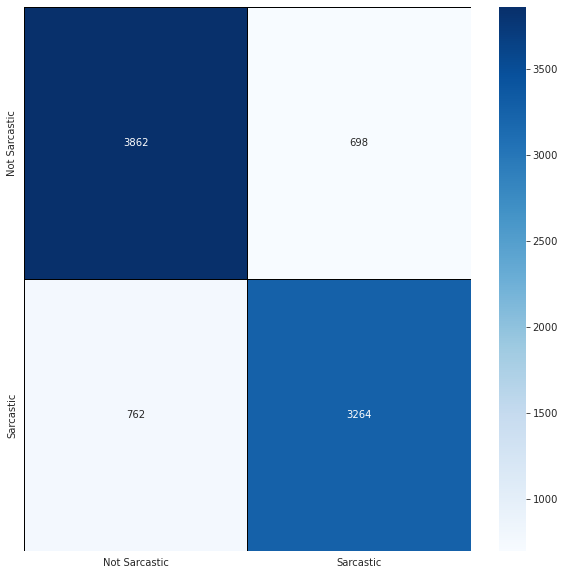

In [87]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

In [100]:
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/nlplab3/nltk_data...


True

#### Example Sentence is "mother comes pretty close to using word 'streaming' correctly"

In [118]:
def preprocess_text(text):
    # Function to preprocess the input text
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    return text

def classify_sentence(sentence, model, tokenizer, maxlen):
    # Preprocess the input sentence
    processed_sentence = preprocess_text(sentence)
    # Tokenize the processed sentence
    tokenized_sentence = tokenizer.texts_to_sequences([processed_sentence])
    # Pad the tokenized sentence to the specified max length
    padded_sentence = keras.utils.pad_sequences(tokenized_sentence, maxlen=maxlen)
    # Predict the class of the sentence using the model
    prediction = model.predict(padded_sentence)
    # Convert prediction to binary label (0 or 1)
    label = "Sarcastic" if prediction > 0.5 else "Not Sarcastic"
    return label

# Example usage:
sentence = input("Enter a sentence: ")
label = classify_sentence(sentence, model, tokenizer, maxlen=200)
print("The input sentence is classified as:", label)

Enter a sentence: mother comes pretty close to using word 'streaming' correctly
1/1 [==============================] - 6s 6s/step
The input sentence is classified as: Sarcastic


In [119]:
import nltk
from nltk.corpus import wordnet

# Perform POS tagging and identify adjectives
def find_adjectives(sentence):
    tagged_words = nltk.pos_tag(nltk.word_tokenize(sentence))
    adjectives = [word for word, pos in tagged_words if pos.startswith('JJ')]
    return adjectives

# Function to find opposites of adjectives using WordNet
def find_opposites(adjectives):
    opposites = {}
    for adj in adjectives:
        synsets = wordnet.synsets(adj)
        for synset in synsets:
            for lemma in synset.lemmas():
                if lemma.antonyms():
                    opposites[adj] = lemma.antonyms()[0].name()
                    break
            if adj in opposites:
                break
    return opposites

# Function to replace adjectives with their opposites in the sentence
def replace_with_opposites(sentence, opposites):
    new_sentence = sentence
    for adj, opposite in opposites.items():
        new_sentence = new_sentence.replace(adj, opposite)
    return new_sentence

def append_not_to_first_adjective(sentence, adjectives):
    # Split the sentence into words
    words = sentence.split()
    # Find the index of the first adjective
    idx = next((i for i, word in enumerate(words) if word in adjectives), None)
    if idx is not None:
        # Add 'not' before the first adjective
        words.insert(idx, 'not')
    else:
        # If no adjectives found, prepend 'not' to the sentence
        words.insert(0, 'not')
    # Join the words back into a sentence
    new_sentence = ' '.join(words)
    return new_sentence


# Example usage:
input_sentence = input()
adjectives = find_adjectives(input_sentence)
opposites = find_opposites(adjectives)
#new_sentence = replace_with_opposites(input_sentence, opposites)
new_sentence = append_not_to_first_adjective(input_sentence, adjectives)

print("Original Sentence:", input_sentence)
print("Adjectives:", adjectives)
print("Opposites:", opposites)
print("New Sentence:", new_sentence)

mother comes pretty close to using word 'streaming' correctly
Original Sentence: mother comes pretty close to using word 'streaming' correctly
Adjectives: ['close']
Opposites: {'close': 'open'}
New Sentence: mother comes pretty not close to using word 'streaming' correctly
